In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
import EnsembleINIT as Ensemble # Init new models
import numpy as np

In [2]:
data = {'real_estate' : ['https://raw.githubusercontent.com/ostapkharysh/PublicDatasets/master/Regression/Real%20estate.csv', ['X2 house age', 'X3 distance to the nearest MRT station', 'X4 number of convenience stores'], 'Y house price of unit area' ],
        'cancer_reg' : ['https://raw.githubusercontent.com/ostapkharysh/PublicDatasets/master/Regression/cancer_reg.csv', ['avgAnnCount', 'avgDeathsPerYear', 'incidenceRate', 'medIncome', 'popEst2015', 
                        'povertyPercent', 'studyPerCap', 'MedianAge', 'AvgHouseholdSize', 'PercentMarried', 'BirthRate', 'PctWhite', 'PctBlack', 'PctAsian', 'PctOtherRace'], 'TARGET_deathRate'],
        'insurance_charge' : ['https://raw.githubusercontent.com/ostapkharysh/PublicDatasets/master/Regression/insuranceCharge.csv', ['age', 'bmi', 'children'], 'charges'], 
        'bike' : ['https://raw.githubusercontent.com/ostapkharysh/PublicDatasets/master/Regression/bike_hour.csv', ['hr', 'holiday', 'weathersit', 'temp', 'atemp','hum', 'windspeed'], 'cnt'],
         }

In [3]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression, LassoLars, ElasticNetCV, BayesianRidge, ARDRegression
from sklearn import metrics

def reg_train(x_train, y_train):
        """
        Returns trained  regression models 
        """
        estimators = dict()
        
        estimators['svr'] = SVR()
        params = {'epsilon':[0.1, 0.01, 0.2, 0.5]}
    
        estimators['svr'] = GridSearchCV(estimators['svr'], params)
        estimators['svr'].fit(x_train, y_train)

        estimators['rfr'] = RandomForestRegressor()
        params = {'max_depth':[1, 1.5, 0.5, 0.1, 2, 5]}
        estimators['rfr'] = GridSearchCV(estimators['rfr'], params)
        estimators['rfr'].fit(x_train, y_train)

        estimators['dtr'] = DecisionTreeRegressor()
        #params = {'criterion':['squared_error', 'friedman_mse', 'absolute_error']}
        params = {'max_depth':[1, 1.5, 0.5, 0.1, 2, 5]}
        estimators['dtr'] = GridSearchCV(estimators['dtr'], params)
        estimators['dtr'].fit(x_train, y_train)

        estimators['lin'] = LinearRegression()
        params = {'fit_intercept':[True, False]}
        estimators['lin'] = GridSearchCV(estimators['lin'], params)
        estimators['lin'].fit(x_train, y_train)
        
        estimators['lasso'] = LassoLars(alpha=.1, normalize=False) #Least Angle Regression
        params = {'fit_intercept':[True, False]}
        estimators['lasso'] = GridSearchCV(estimators['lasso'], params)
        estimators['lasso'].fit(x_train, y_train)
        
        estimators['elastic'] = ElasticNetCV()
        estimators['elastic'] = GridSearchCV(estimators['elastic'], params)
        estimators['elastic'].fit(x_train, y_train)
        
        estimators['bayes'] = BayesianRidge()
        estimators['bayes'] = GridSearchCV(estimators['bayes'], params)
        estimators['bayes'].fit(x_train, y_train)
        
        estimators['ARD'] = ARDRegression()
        estimators['ARD'] = GridSearchCV(estimators['ARD'], params)
        estimators['ARD'].fit(x_train, y_train)

        return estimators

def reg_scoring(y, yhat):
    """
    Returns regression scores
    """
    scores = dict()
    scores['mae'] = metrics.mean_absolute_error(y, yhat)
    scores['mse'] = metrics.mean_squared_error(y, yhat)
    scores['squared_error'] = np.square(np.subtract(y, yhat))
    scores['rmse'] = scores['mse']**(0.5) 
    return scores

def reg_prediction(df, df_competition, line, X, Y):
    """
    Predict Y for regression and record the error
    """
    # Declare the vars
    errors = dict()
    errors = {'svr':[], 'lin': [], 'dtr':[], 'rfr':[], 'lasso':[], 'elastic': [], 'bayes': [], 'ARD': []}
    
    ######### TRAIN THE MODEL ###########
    #x_train = df.drop(columns = [target_column[line]])
    #y_train = df[target_column[line]]
    
    x_train = df[X]
    y_train = df[Y]
    
    estimators = reg_train(x_train.values, y_train.values) # train estimators

    ######### TEST THE MODEL ###########
    x_competition = df_competition[X]
    y_competition = df_competition[Y]
    
    ######### SCORE THE MODEL ###########
    for est in estimators.keys():
        y_est = estimators[est].predict(x_competition.values)
        errors[est] = reg_scoring(y=y_competition, yhat=y_est)['squared_error']

    # return the data
    return errors, estimators

In [4]:
results = {}
columns_to_drop = [[],['Geography','binnedInc'],['sex','smoker','region'],['instant','dteday']]

for idx, el in enumerate(data):
        print("Dataset: " + el)

        results[el] = list()
        
        df = pd.read_csv(data[el][0], encoding="ISO-8859-1")
        df.drop(columns = columns_to_drop[idx],inplace = True)
        df = df.dropna()
        
        if el == 'real_estate':
            print("worked")
            df = df.round(1)
        ds, competition = train_test_split(df, test_size=0.3)
        ds = ds.reset_index(drop=True)
        competition = competition.reset_index(drop=True)
        print(el)
        print(ds.shape)
        print(competition.shape)
        
        #Estimators to compare
        m_errors, estimators = reg_prediction(ds,competition,idx, X=data[el][1], Y=data[el][2])
        print("Estimators Finished")
        
        #Beta = 3
        
        #Assembly without priority
        assembly = Ensemble.analyze_ensemble(learning_ds=ds, competition_ds=competition, X=data[el][1], Y=data[el][2],
                                                         priority = False, beta=3)
        m_errors["Ens3"] = assembly['squared_error']
        
        #Assembly with priority
        assembly = Ensemble.analyze_ensemble(learning_ds=ds, competition_ds=competition, X=data[el][1], Y=data[el][2],
                                                         priority = True, beta=3)
        m_errors["Ens3Priority"] = assembly['squared_error']
        
        #Assembly without priority + exp
        assembly = Ensemble.analyze_ensemble(learning_ds=ds, competition_ds=competition, X=data[el][1], Y=data[el][2],
                                                         priority = False, approach='exp', beta=3)
        m_errors["EXPEns3"] = assembly['squared_error']
        #Assembly with priority + exp
        assembly = Ensemble.analyze_ensemble(learning_ds=ds, competition_ds=competition, X=data[el][1], Y=data[el][2],
                                                         priority = True, approach='exp', beta=3)
        m_errors["EXPEns3priority"] = assembly['squared_error']
        
        
        #Beta = 5
        #Assembly without priority
        assembly = Ensemble.analyze_ensemble(learning_ds=ds, competition_ds=competition, X=data[el][1], Y=data[el][2],
                                                         priority = False, beta=5)
        m_errors["Ens5"] = assembly['squared_error']
        
        #Assembly with priority
        assembly = Ensemble.analyze_ensemble(learning_ds=ds, competition_ds=competition, X=data[el][1], Y=data[el][2],
                                                         priority = True, beta=5)
        m_errors["Ens5Priority"] = assembly['squared_error']
        
        #Assembly without priority + exp
        assembly = Ensemble.analyze_ensemble(learning_ds=ds, competition_ds=competition, X=data[el][1], Y=data[el][2],
                                                         priority = False, approach='exp', beta=5)
        m_errors["EXPEns5"] = assembly['squared_error']
        #Assembly with priority + exp
        assembly = Ensemble.analyze_ensemble(learning_ds=ds, competition_ds=competition, X=data[el][1], Y=data[el][2],
                                                         priority = True, approach='exp', beta=5)
        m_errors["EXPEns5priority"] = assembly['squared_error']
        
        
        #TOGETHER
        results[el].append(m_errors)
        print("Assembly Finished")

Dataset: real_estate
worked
real_estate
(289, 8)
(125, 8)
Estimators Finished
Beta 3
[96, 192, 288]
Part Completed
Beta 3
[96, 192, 288]
Part Completed
Beta 3
[96, 192, 288]
Part Completed
Beta 3
[96, 192, 288]
Part Completed
Beta 5
[57, 114, 171, 228, 285]
Part Completed
Beta 5
[57, 114, 171, 228, 285]
Part Completed
Beta 5
[57, 114, 171, 228, 285]
Part Completed
Beta 5
[57, 114, 171, 228, 285]
Part Completed
Assembly Finished
Dataset: cancer_reg
cancer_reg
(413, 32)
(178, 32)
Estimators Finished
Beta 3
[137, 274, 411]
Part Completed
Beta 3
[137, 274, 411]
Part Completed
Beta 3
[137, 274, 411]
Part Completed
Beta 3
[137, 274, 411]
Part Completed
Beta 5
[82, 164, 246, 328, 410]
Part Completed
Beta 5
[82, 164, 246, 328, 410]
Part Completed
Beta 5
[82, 164, 246, 328, 410]
Part Completed
Beta 5
[82, 164, 246, 328, 410]
Part Completed
Assembly Finished
Dataset: insurance_charge
insurance_charge
(936, 4)
(402, 4)
Estimators Finished
Beta 3
[312, 624, 936]
Part Completed
Beta 3
[312, 624, 93

In [5]:
#results

In [6]:
data

{'real_estate': ['https://raw.githubusercontent.com/ostapkharysh/PublicDatasets/master/Regression/Real%20estate.csv',
  ['X2 house age',
   'X3 distance to the nearest MRT station',
   'X4 number of convenience stores'],
  'Y house price of unit area'],
 'cancer_reg': ['https://raw.githubusercontent.com/ostapkharysh/PublicDatasets/master/Regression/cancer_reg.csv',
  ['avgAnnCount',
   'avgDeathsPerYear',
   'incidenceRate',
   'medIncome',
   'popEst2015',
   'povertyPercent',
   'studyPerCap',
   'MedianAge',
   'AvgHouseholdSize',
   'PercentMarried',
   'BirthRate',
   'PctWhite',
   'PctBlack',
   'PctAsian',
   'PctOtherRace'],
  'TARGET_deathRate'],
 'insurance_charge': ['https://raw.githubusercontent.com/ostapkharysh/PublicDatasets/master/Regression/insuranceCharge.csv',
  ['age', 'bmi', 'children'],
  'charges'],
 'bike': ['https://raw.githubusercontent.com/ostapkharysh/PublicDatasets/master/Regression/bike_hour.csv',
  ['hr', 'holiday', 'weathersit', 'temp', 'atemp', 'hum', '

real_estate
              svr         lin         dtr         rfr       lasso     elastic  \
count  125.000000  125.000000  125.000000  125.000000  125.000000  125.000000   
mean    60.104737   71.880394   60.021217   58.511012   71.749792   74.404305   
std     90.549145  120.017102  109.417920  105.471815  119.779597  114.537613   
min      0.001732    0.015037    0.056982    0.000072    0.009506    0.000270   
25%      4.267419    7.177952    4.075352    5.671454    7.264546    5.568088   
50%     26.960345   29.047934   19.830322   20.813285   29.002519   23.709456   
75%     70.457916   86.556692   65.306602   56.926759   87.035377  103.930294   
max    514.851694  771.916627  711.111111  589.464713  768.971416  697.144341   

            bayes          ARD        Ens3  Ens3Priority     EXPEns3  \
count  125.000000   125.000000  125.000000    125.000000  125.000000   
mean    71.267757   105.827610   63.656095     70.455492   64.362693   
std    119.057797   149.394222   96.212429

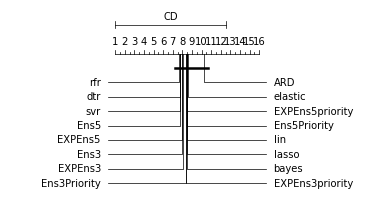

cancer_reg
                svr          lin          dtr          rfr        lasso  \
count    178.000000   178.000000   178.000000   178.000000   178.000000   
mean     817.307332   520.721464   586.677546   477.361783   519.383308   
std     1444.447648   908.278660  1033.445806   926.661169   907.441458   
min        0.002813     0.039072     0.006194     0.000172     0.185030   
25%       69.842843    28.860608    35.645121    33.370812    28.740711   
50%      299.808725   159.710862   200.594513   121.332578   149.980991   
75%      884.772168   518.036628   771.515924   472.084413   514.437706   
max    12785.550229  5871.137251  8708.864342  7346.935329  5849.835869   

            elastic        bayes          ARD         Ens3  Ens3Priority  \
count    178.000000   178.000000   178.000000   178.000000    178.000000   
mean     719.799420   528.710848   509.761736   582.044040    519.290118   
std     1281.052983   914.073710   861.026083  1043.029542    886.728893   
min      

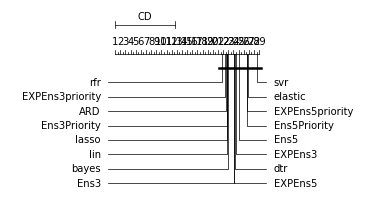

insurance_charge
                svr           lin           dtr           rfr         lasso  \
count  4.020000e+02  4.020000e+02  4.020000e+02  4.020000e+02  4.020000e+02   
mean   1.645628e+08  1.271388e+08  1.354179e+08  1.336829e+08  1.271390e+08   
std    3.491868e+08  2.094327e+08  2.302933e+08  2.269399e+08  2.094329e+08   
min    2.578710e+03  3.457943e+05  4.528184e+02  2.689363e+05  3.458532e+05   
25%    8.280500e+06  2.665057e+07  2.268995e+07  2.122644e+07  2.664953e+07   
50%    2.697585e+07  4.798734e+07  4.610348e+07  4.392040e+07  4.798792e+07   
75%    6.529585e+07  8.707048e+07  1.152472e+08  9.906939e+07  8.707196e+07   
max    1.560591e+09  1.023325e+09  1.289207e+09  1.204149e+09  1.023324e+09   

            elastic         bayes           ARD          Ens3  Ens3Priority  \
count  4.020000e+02  4.020000e+02  4.020000e+02  4.020000e+02  4.020000e+02   
mean   1.306701e+08  1.276504e+08  1.280672e+08  1.326972e+08  1.632627e+08   
std    2.269578e+08  2.108061e+08 

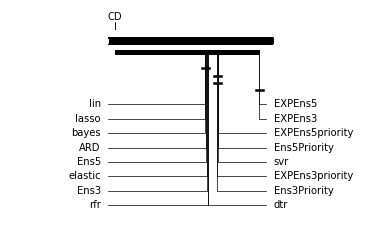

bike
                 svr            lin            dtr            rfr  \
count    5214.000000    5214.000000    5214.000000    5214.000000   
mean    23306.332216   22150.498715   13881.632452   13118.398847   
std     56349.103695   46658.018862   30291.588466   29162.576129   
min         0.000297       0.000079       0.000632       0.000060   
25%       419.401301    1452.061448     268.231605     279.750277   
50%      3367.014717    6957.752035    2311.529437    2286.572397   
75%     16932.343992   21541.688416   11674.044042   11266.307808   
max    515740.962669  513208.659448  351712.576429  340289.161847   

               lasso        elastic          bayes            ARD  \
count    5214.000000    5214.000000    5214.000000    5214.000000   
mean    22159.430177   26643.623106   22152.910250   22154.904148   
std     46709.804371   53139.094087   46670.443184   46713.675348   
min         0.000137       0.001921       0.000365       0.000449   
25%      1437.623711    2544

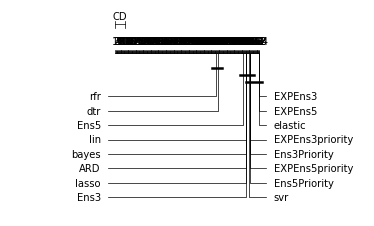

In [7]:
import Orange
import matplotlib.pyplot as plt
import numpy as np

#RESULTS GENERATION


for i, dataname in enumerate(data):
    
    df_results = pd.DataFrame.from_dict(results[dataname][0])
    #df_results['assembly'] = errors['squared_error']

    #df_results = pd.DataFrame.from_dict([results[dataname][1], results[dataname][0]])
    print(dataname)
    print(df_results.describe())
    
    names = list(df_results.columns.values)
    #names.append('assembly')
    avranks = df_results.mean()**(0.5)
    #avranks = avranks.append(pd.Series(df_resultsAsm[i], index=['assembly']))
    print(avranks)
    cd = Orange.evaluation.compute_CD(avranks, 4,alpha="0.05") #tested on 4 datasets 
    print("cd=",cd)
    Orange.evaluation.graph_ranks(avranks, names, cd=cd, width=5, textspace=1.5)
    plt.show();

In [1]:
#TIME SERIES PART STARTS HERE

In [8]:
ts_data = {
           'bike' : ['https://raw.githubusercontent.com/ostapkharysh/PublicDatasets/master/Regression/bike_hour.csv', 'cnt'], 
           'ibm' : ['https://raw.githubusercontent.com/PacktPublishing/Practical-Time-Series-Analysis/master/Data%20Files/ibm-common-stock-closing-prices.csv', 'IBM common stock closing prices'],
            'ozone': ['https://raw.githubusercontent.com/PacktPublishing/Practical-Time-Series-Analysis/master/Data%20Files/monthly-mean-thickness-dobson-un.csv', 'Monthly mean thickness (Dobson units) ozone column Arosa, Switzerland 1926-1971'], 
            'temperature': ['https://raw.githubusercontent.com/PacktPublishing/Practical-Time-Series-Analysis/master/Data%20Files/mean-daily-temperature-fisher-river.csv', 'Mean temparature']  
}

In [9]:
ts_results = {}
columns_to_drop = [[],['Geography','binnedInc'],['sex','smoker','region'],['instant','dteday'],[]]

def make_dataset_from_ts(d, num_x=10, value=None):
    """
    Set the amount of previous observations to predict the next observation
    """
    for idx in range(num_x):
        d['t-' + str(idx+1)] = d[value].shift(+(idx+1))
    return d[num_x:]

In [12]:
import warnings
from sklearn.exceptions import ConvergenceWarning
with warnings.catch_warnings():
    warnings.filterwarnings("ignore", category=ConvergenceWarning)
    

    for idx, el in enumerate(ts_data):

        ts_results[el] = list()

        Y = ts_data[el][1]
        df = pd.read_csv(ts_data[el][0], encoding="ISO-8859-1")
        df = make_dataset_from_ts(df[[Y]], value=Y) #TS

        if el =='ibm':
            df = df[:-1] #THERE WAS A NAN in the last column during the reading
            df = df[df[Y].notna()] # There were still some ones in the
            df[Y] = pd.to_numeric(df[Y])
        elif el =='precipitation':
            df = df[:-2] #THERE WAS A NAN and String in the last columns during the reading
            df = df[df[Y].notna()] # There were still some ones in the
            df[Y] = pd.to_numeric(df[Y])
        elif el =='ozone':
            df = df[:-2] #THERE WAS A NAN and String in the last columns during the reading
            df = df[df[Y].notna()] # There were still some nones in the
            df[Y] = pd.to_numeric(df[Y])

        X = list(df.columns[1:]) #TS
        ds, competition = train_test_split(df, test_size=0.3, shuffle = False)
        ds = ds.reset_index(drop=True)
        competition = competition.reset_index(drop=True)
        print(el)
        
        #Estimators to compare
        m_errors, estimators = reg_prediction(ds, competition, idx, X=X, Y=Y)

        
        #BETA + 3
        
        #Assembly without priority
        assembly = Ensemble.analyze_ensemble(learning_ds=ds, competition_ds=competition, X=X, Y=Y,
                                                         priority = False, beta=3)
        m_errors["Ens3"] = assembly['squared_error']
        
        #Assembly with priority
        assembly = Ensemble.analyze_ensemble(learning_ds=ds, competition_ds=competition, X=X, Y=Y,
                                                         priority = True, beta=3)
        m_errors["Ens3Priority"] = assembly['squared_error']
        
        #Assembly without priority + exp
        assembly = Ensemble.analyze_ensemble(learning_ds=ds, competition_ds=competition, X=X, Y=Y,
                                                         priority = False, approach='exp', beta=3)
        m_errors["EXPEns3"] = assembly['squared_error']
        #Assembly with priority + exp
        assembly = Ensemble.analyze_ensemble(learning_ds=ds, competition_ds=competition, X=X, Y=Y,
                                                         priority = True, approach='exp', beta=3)
        m_errors["EXPEns3priority"] = assembly['squared_error']
        
        
        
        #BETA = 5


        #Assembly without priority
        assembly = Ensemble.analyze_ensemble(learning_ds=ds, competition_ds=competition, X=X, Y=Y,
                                                         priority = False, beta=5)
        m_errors["Ens5"] = assembly['squared_error']
        
        #Assembly with priority
        assembly = Ensemble.analyze_ensemble(learning_ds=ds, competition_ds=competition, X=X, Y=Y,
                                                         priority = True, beta=5)
        m_errors["Ens5Priority"] = assembly['squared_error']
        
        #Assembly without priority + exp
        assembly = Ensemble.analyze_ensemble(learning_ds=ds, competition_ds=competition, X=X, Y=Y,
                                                         priority = False, approach='exp', beta=5)
        m_errors["EXPEns5"] = assembly['squared_error']
        #Assembly with priority + exp
        assembly = Ensemble.analyze_ensemble(learning_ds=ds, competition_ds=competition, X=X, Y=Y,
                                                         priority = True, approach='exp', beta=5)
        m_errors["EXPEns5priority"] = assembly['squared_error']
        
        
        #TOGETHER
        ts_results[el].append(m_errors)
        print("Assembly Finished")

<ipython-input-9-f26a1e88bcb7>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  d['t-' + str(idx+1)] = d[value].shift(+(idx+1))


bike
Beta 3
[4052, 8104, 12156]
Part Completed
Beta 3
[4052, 8104, 12156]
Part Completed
Beta 3
[4052, 8104, 12156]
Part Completed
Beta 3
[4052, 8104, 12156]
Part Completed
Beta 5
[2431, 4862, 7293, 9724, 12155]
Part Completed
Beta 5
[2431, 4862, 7293, 9724, 12155]
Part Completed
Beta 5
[2431, 4862, 7293, 9724, 12155]
Part Completed
Beta 5
[2431, 4862, 7293, 9724, 12155]
Part Completed
Assembly Finished
ibm
Beta 3
[232, 464, 696]
Part Completed
Beta 3
[232, 464, 696]
Part Completed
Beta 3
[232, 464, 696]
Part Completed
Beta 3
[232, 464, 696]
Part Completed
Beta 5
[139, 278, 417, 556, 695]
Part Completed
Beta 5
[139, 278, 417, 556, 695]
Part Completed
Beta 5
[139, 278, 417, 556, 695]
Part Completed
Beta 5
[139, 278, 417, 556, 695]
Part Completed
Assembly Finished
ozone
Beta 3
[118, 236, 354]
Part Completed
Beta 3
[118, 236, 354]
Part Completed
Beta 3
[118, 236, 354]
Part Completed
Beta 3
[118, 236, 354]
Part Completed
Beta 5
[70, 140, 210, 280, 350]
Part Completed
Beta 5
[70, 140, 210, 


bike

                 svr            lin            dtr            rfr  \
count    5211.000000    5211.000000    5211.000000    5211.000000   
mean    26904.388763   11711.623702    9589.508698    8302.234363   
std     62083.404575   25775.400056   24002.499603   21601.708969   
min         0.000010       0.000023       0.000464       0.004410   
25%       499.581091     408.898577     225.646531     205.513855   
50%      3317.164651    2443.709298    1662.788352    1442.767341   
75%     16589.759692    9325.964113    8050.490752    6905.812224   
max    508844.038053  232451.939433  293712.383220  283153.208000   

               lasso        elastic          bayes            ARD  \
count    5211.000000    5211.000000    5211.000000    5211.000000   
mean    11711.680917   11792.750777   11712.432400   11710.317957   
std     25775.622549   25895.625411   25773.985186   25770.983450   
min         0.000105       0.000497       0.000035       0.000056   
25%       408.857638     4

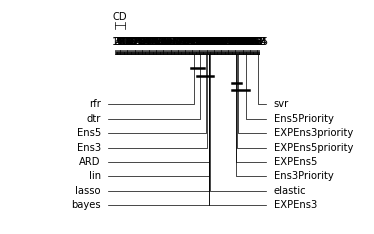


ibm

                svr         lin          dtr           rfr       lasso  \
count  3.000000e+02  300.000000   300.000000  3.000000e+02  300.000000   
mean   4.438060e+01   16.303844    58.887088  2.746978e+01   16.315363   
std    6.956656e+01   26.414892   144.582057  4.561138e+01   26.460549   
min    1.095323e-09    0.000543     0.006457  2.400005e-07    0.000025   
25%    5.123534e+00    1.028124     2.856100  1.506987e+00    1.022531   
50%    2.245377e+01    6.333043    13.700306  1.050120e+01    6.342722   
75%    5.662823e+01   21.568919    46.922500  3.233303e+01   21.525712   
max    7.951083e+02  199.001430  1350.562500  3.362234e+02  199.870707   

          elastic       bayes         ARD        Ens3  Ens3Priority  \
count  300.000000  300.000000  300.000000  300.000000    300.000000   
mean    16.569328   16.357512   16.359557   17.116846    119.506337   
std     26.701912   26.575951   26.866881   26.380241    181.924470   
min      0.000796    0.000035    0.000002  

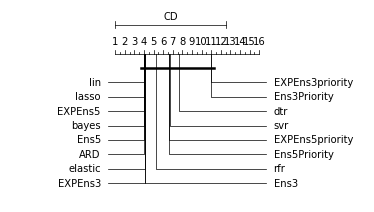


ozone

               svr          lin          dtr          rfr        lasso  \
count   153.000000   153.000000   153.000000   153.000000   153.000000   
mean    543.518449   373.439683   569.826179   358.599515   373.550030   
std     858.620679   583.740947   925.324534   531.256987   584.165707   
min       0.012821     0.000389     0.052674     0.054472     0.000699   
25%      31.193816    46.294660    52.562500    29.836845    46.223857   
50%     210.975414   152.834663   196.000000   136.746927   152.888734   
75%     632.030616   514.423036   628.128906   484.573130   513.874528   
max    5357.890187  4379.519794  4761.000000  3755.885227  4383.690876   

           elastic        bayes          ARD         Ens3  Ens3Priority  \
count   153.000000   153.000000   153.000000   153.000000    153.000000   
mean    386.390386   375.049066   389.177938   413.077417    703.443945   
std     625.287908   583.950172   633.748430   666.476694   1072.149348   
min       0.000298     0.

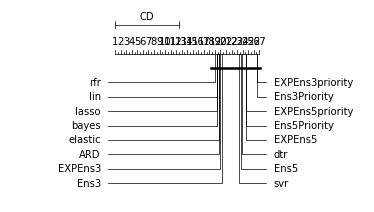


temperature

              svr         lin         dtr         rfr       lasso     elastic  \
count  436.000000  436.000000  436.000000  436.000000  436.000000  436.000000   
mean    22.746820   16.810988   21.066863   17.864888   16.852342   16.978374   
std     34.068137   26.808652   39.191423   28.294400   26.954481   27.181032   
min      0.000116    0.000165    0.001162    0.000190    0.000054    0.000007   
25%      1.828608    1.299812    1.304989    1.438957    1.267309    1.213317   
50%      9.150517    6.874336    7.406224    6.747232    6.865453    6.864525   
75%     30.305263   21.331559   23.681291   21.536064   21.906567   21.826451   
max    212.123136  207.815098  451.562500  207.529320  207.433806  204.625624   

            bayes         ARD        Ens3  Ens3Priority     EXPEns3  \
count  436.000000  436.000000  436.000000    436.000000  436.000000   
mean    16.854435   16.870950   20.929851     26.034707   24.456240   
std     26.850766   27.275644   37.953453  

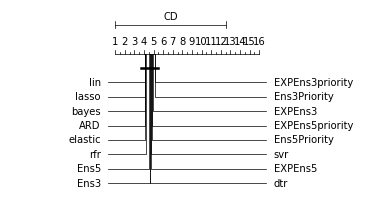

In [13]:
#RESULTS GENERATION
for i, dataname in enumerate(ts_data):
    
    df_results = pd.DataFrame.from_dict(ts_results[dataname][0])
    
    print()
    print(dataname)
    print()
    print(df_results.describe())
    
    
    names = list(df_results.columns.values)
    #names.append('assembly')
    avranks = df_results.mean()**(0.5)
    #avranks = avranks.append(pd.Series(df_resultsAsm[i], index=['assembly']))
    print(avranks)
    cd = Orange.evaluation.compute_CD(avranks, 4,alpha="0.05") #tested on 4 datasets 
    print("cd=",cd)
    Orange.evaluation.graph_ranks(avranks, names, cd=cd, width=5, textspace=1.5)
    plt.show();